In [5]:
import numpy as np
import torch
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
print(f"PyTorch version:[{(torch.__version__)}].")

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"This notebook use {(device)}")

PyTorch version:[1.7.0+cu101].
This notebook use cuda:0


In [6]:
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.001

In [7]:
from torchvision import datasets, transforms, models

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229,0.224,0.225])])

test_transfomrs = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/ball_dataset'

train_data = datasets.ImageFolder(DATASET_PATH + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(DATASET_PATH + '/test', transform=test_transfomrs)

train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print("Preparing dataset done!")

Preparing dataset done!


In [8]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

# Define Model

In [9]:
class Model(nn.Module):
    def __init__(self, input_size=[3,224,224],
                 hidden_size=[32,64],
                 num_classes=7, init_weight="he", init_bias="zero"):
        super(Model, self).__init__()

        self.init_weight = init_weight
        self.init_bias = init_bias

        layer_list = []
        prev_channel = input_size[0]

        for idx in range(len(hidden_size)):
            layer_list.append(nn.Conv2d(prev_channel, hidden_size[idx], kernel_size=3, stride=1, padding=1))
            layer_list.append(nn.BatchNorm2d(hidden_size[idx]))
            layer_list.append(nn.ReLU(True))
            layer_list.append(nn.MaxPool2d(kernel_size=2, stride=2))
            prev_channel = hidden_size[idx]

        layer_list.append(nn.Flatten())
        feature_size = int(input_size[1]/ 2**len(hidden_size))
        layer_list.append(nn.Linear(feature_size*feature_size*prev_channel, 7))

        self.net = nn.Sequential(*layer_list)

        self.init_params()
    
    
    def init_params(self):

        init_weight_method = {
            "he": nn.init.kaiming_normal_,
            "xavier":nn.init.xavier_normal_
        }
        assert self.init_weight in init_weight_method.keys(), f'Select the weight initialization method in {list(init_weight_method.keys())}'

        init_bias_method = {
            "zero":nn.init.zeros_,
            "uniform":nn.init.uniform_
        }
        assert self.init_bias in init_bias_method.keys(), f'Select the bias initialization method in {list(init_bias_method.keys())}'


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weight_method[self.init_weight](m.weight)
                init_bias_method[self.init_bias](m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, X):
        return self.net(X)


In [10]:
model = Model(hidden_size=[64,32,64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
total_params = 0
for param_name, param in model.named_parameters():
    if param.requires_grad:
        total_params += len(param.reshape(-1))
print(f'Number of Total Parameters: {total_params:,d}')

Number of Total Parameters: 390,311


# Define help function

In [12]:
def test_eval(model, data_iter, batch_size):
    with torch.no_grad():
        test_loss = 0
        total = 0
        correct = 0
        model.eval()
        for batch_img, batch_lab in data_iter:
            X = batch_img.view(-1, 3, 224, 224).to(device)
            Y = batch_lab.to(device)
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == Y).sum().item()
            total += batch_img.size(0)
        val_acc = (100 * correct / total)
        model.train()
    return val_acc

In [13]:
type(train_iter)

torch.utils.data.dataloader.DataLoader

In [21]:
import warnings
from PIL import UnidentifiedImageError

warnings.filterwarnings(action='ignore')

# Training Phase
print_every = 1
best_accuracy = 0
print("Strart training !")
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/ball_dataset/weights"

if os.path.exists(checkpoint_dir):
    model = torch.load(f'{checkpoint_dir}/model.pt')
    model.load_state_dict(
        torch.load( f'{checkpoint_dir}/model_state_dict.pt')) 
    checkpoint = torch.load(f'{checkpoint_dir}/all.tar')
    # model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

else:
    model = Model(hidden_size=[64,32,64]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Training loop
num = 0
for epoch in range(EPOCHS):
    loss_val_sum = 0
    train__ = iter(train_iter)    
    
    while train__:
        try:
            batch_img, batch_lab = train__.next()
            # print(type(train__.next()))
            X = batch_img.view(-1, 3, 224, 224).to(device)
            Y = batch_lab.to(device)

            # Inference % Calculate los
            y_pred = model.forward(X)
            loss = criterion(y_pred, Y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_val_sum += loss
            # print("good")
        
        except StopIteration:
            break
        except UnidentifiedImageError:
            print("image error")
            pass
    
        
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        # acc_val = M.test(x_test, y_test, batch_size)
        loss_val_avg = loss_val_sum / len(train_iter)
        accr_val = test_eval(model, test_iter, BATCH_SIZE)
        print(f'epoch:[{epoch+1}/{EPOCHS}] cost:[{loss_val_avg:.3f}] test_accuracy:[{accr_val:.3f}]')

    if accr_val > best_accuracy:
        if not os.path.exists(checkpoint_dir):
            os.mkdir(checkpoint_dir)
        print(f'Model saved : acc - {accr_val}')

        torch.save(model, f'{checkpoint_dir}/model.pt')
        torch.save(model.state_dict(),
                   f'{checkpoint_dir}/model_state_dict.pt')
        torch.save({
            'model':model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, f'{checkpoint_dir}/all.tar')

    print("Training Done !")


Strart training !
image error
epoch:[1/10] cost:[6.374] test_accuracy:[43.069]
Model saved : acc - 43.06930693069307
Training Done !
image error
epoch:[2/10] cost:[6.416] test_accuracy:[43.564]
Model saved : acc - 43.56435643564357
Training Done !
image error
epoch:[3/10] cost:[6.820] test_accuracy:[43.069]
Model saved : acc - 43.06930693069307
Training Done !
image error
epoch:[4/10] cost:[6.479] test_accuracy:[43.069]
Model saved : acc - 43.06930693069307
Training Done !
image error
epoch:[5/10] cost:[6.790] test_accuracy:[43.564]
Model saved : acc - 43.56435643564357
Training Done !
image error
epoch:[6/10] cost:[6.845] test_accuracy:[43.564]
Model saved : acc - 43.56435643564357
Training Done !
image error
epoch:[7/10] cost:[6.550] test_accuracy:[45.050]
Model saved : acc - 45.04950495049505
Training Done !
image error
epoch:[8/10] cost:[6.644] test_accuracy:[43.564]
Model saved : acc - 43.56435643564357
Training Done !
image error
epoch:[9/10] cost:[6.348] test_accuracy:[44.059]
M

In [22]:
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
data_iter = iter(test_iter)
images, labels = next(data_iter)

In [27]:
ball_list = ['baseball','baseketball','football','golf','rugby','tennis','volleyball']

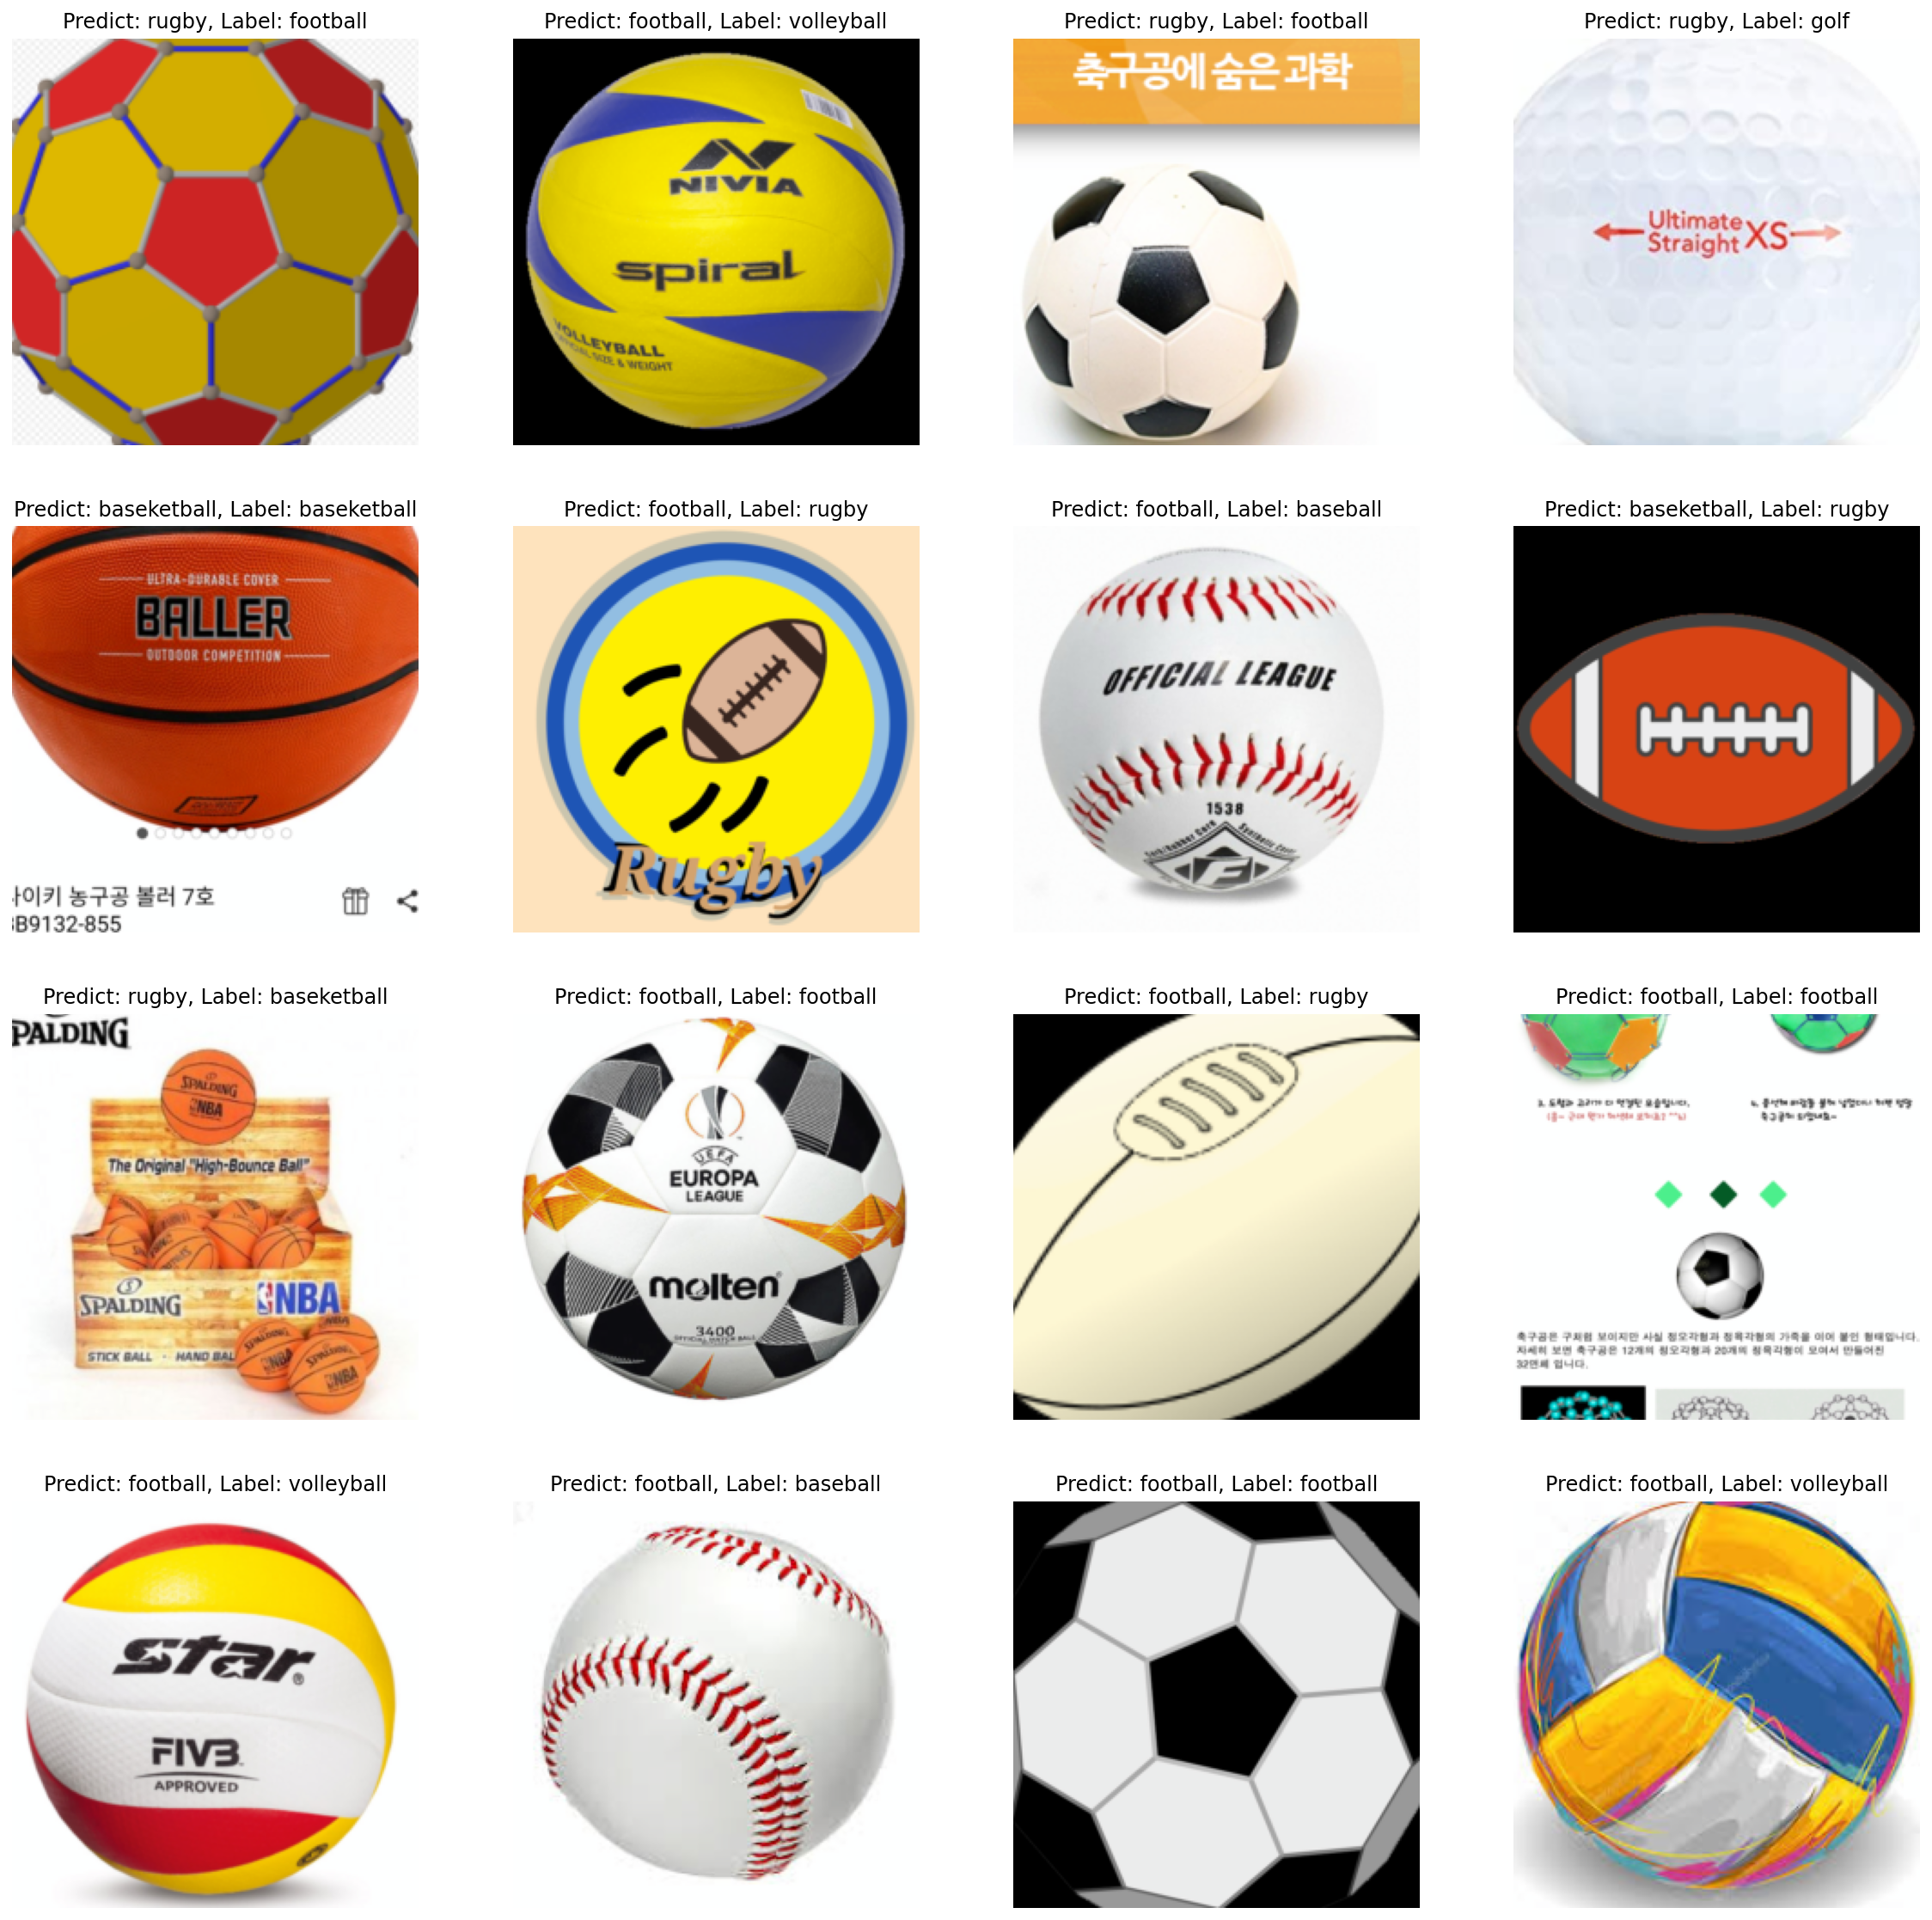

In [28]:

n_sample = 16
# sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = images[:n_sample]
test_y = labels[:n_sample]

with torch.no_grad():
    model.eval()
    y_pred = model.forward(test_x.view(-1, 3, 224, 224).type(torch.float).to(device))
    model.train()
    
y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(20, 20))

for idx in range(n_sample):
    ax = plt.subplot(4, 4, idx+1)
    title_ = f"Predict: {ball_list[y_pred[idx]]}, Label: {ball_list[test_y[idx]]}"
    imshow(test_x[idx], ax)
    plt.title(title_)

plt.show()